# Anomaly Detection of Traffic Volumes via ARIMA Modelling
***

In [1]:
%load_ext rpy2.ipython
import pandas as pd
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
from sqlalchemy import create_engine
import io
import datetime 
import numpy 
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages('forecast')

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)
pd.options.display.mpl_style = 'default'


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


# **15-Minute Anomaly Detection**

## Forecasting Traffic Volume with an ARIMA Model
***
Before automating the forecasting function, lets see how we will forecast 24 hour traffic data. 

<br>
Our goal is as follows: given a day of the week, intersection, direction, and leg, we wish to forecast traffic volume of the next 24 hours corresponding to that day of the week. We will do this via ARIMA modelling. How do we know 24 hour traffic data can be modelled via an ARIMA model? Consider the PACF and ACF of a Thursday at Front and Spadina going EB via the West Leg. 

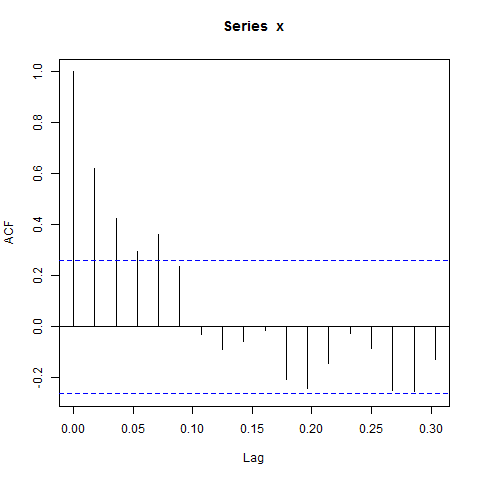

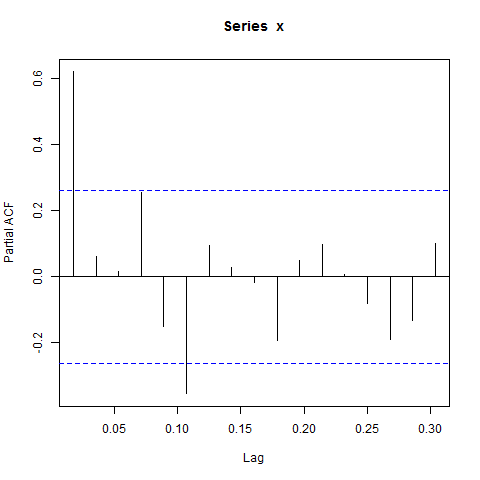

R object with classes: ('acf',) mapped to:
<ListVector - Python:0x000000000D8AF4C8 / R:0x000000000EA9C280>
[Array, StrVe..., IntVe..., Array, StrVe..., RNULL...]
  acf: <class 'rpy2.robjects.vectors.Array'>
  R object with classes: ('array',) mapped to:
<Array - Python:0x000000000D8AF408 / R:0x00000000145AFDC8>
[0.621426, 0.061664, 0.015924, 0.256399, ..., -0.080072, -0.188687, -0.130933, 0.101269]
  type: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x000000000D8CEC88 / R:0x000000000E089138>
['partial']
  n.used: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x000000000D3A6548 / R:0x000000000E087F88>
[56]
  lag: <class 'rpy2.robjects.vectors.Array'>
  R object with classes: ('array',) mapped to:
<Array - Python:0x000000000599C188 / R:0x00000000145B0870>
[0.017857, 0.035714, 0.053571, 0.071429, ..., 0.250000, 0.267857, 0.285714, 0.303571]
  series: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x000000000D8C9A48 / R:0x000000000E087D18>
['x']
  snames: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL

In [2]:
strSQL = '''WITH ts AS (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
            INNER JOIN miovision.intersections USING (intersection_uid)
            WHERE classification_uid in (1,4,5)
            AND intersection_name = 'Front / Spadina'
            AND (leg = 'W' AND dir = 'EB')
            AND extract(dow from datetime_bin) = 2
            and extract('month' from datetime_bin) = 2
            and extract('hour' from datetime_bin) >= 6
            and extract('hour' from datetime_bin) < 20
            GROUP BY datetime_bin
            ORDER BY datetime_bin),
            
            proper AS (SELECT datetime_bin::date, COUNT(volume)
            from ts
            group by datetime_bin::date
            having count(volume) = 56)
            
            select * from ts
            where datetime_bin::date in (select datetime_bin from proper)'''
data = pandasql.read_sql(pg.SQL(strSQL), con)
% R  library('forecast')
% R -i data
% R x <- ts(data$volume, frequency = 56)
% R acf(x)
% R pacf(x)


As seen above, the ACF decays after lag 1, and the PACF cuts off after lag 1. This decaying and cutting off behaviour of the ACF and PACF respectively is typical ARIMA model behaviour. 

<br>
We will use R's `auto.arima()` function to automatically fit ARIMA models to our data. Using historical data corresponding to a particular day of the week, intersection, leg, direction, and time series frequency, R will forecast the next 24 hours. A plot of an example can be seen below. 

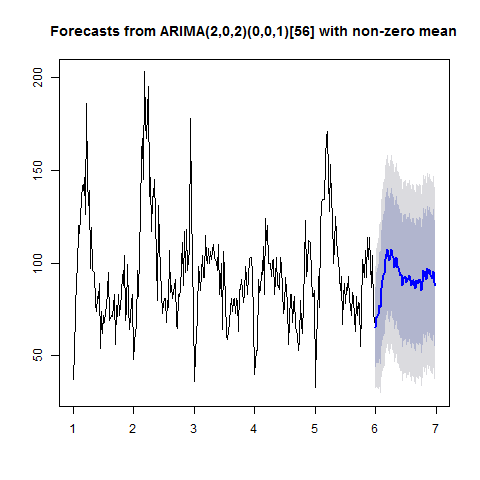

R object with classes: ('list',) mapped to:
<ListVector - Python:0x000000000584A5C8 / R:0x00000000112FBB48>
[FloatVector, Matrix, Matrix]
  mean: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('ts',) mapped to:
<FloatVector - Python:0x000000000584A488 / R:0x00000000145A1390>
[65.363227, 70.729437, 72.355672, 77.251008, ..., 91.534549, 95.637871, 89.345074, 87.772595]
  lower: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('mts', 'ts', 'matrix') mapped to:
<Matrix - Python:0x000000000D8CE548 / R:0x000000000EA54538>
[43.994262, 46.559313, 45.743841, 48.625540, ..., 39.730504, 43.833616, 37.540650, 35.968047]
  upper: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('mts', 'ts', 'matrix') mapped to:
<Matrix - Python:0x000000000D3A5DC8 / R:0x0000000012770808>
[86.732191, 94.899561, 98.967503, 105.876475, ..., 143.338594, 147.442127, 141.149498, 139.577143]

In [3]:
strSQL = '''WITH ts AS (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
            INNER JOIN miovision.intersections USING (intersection_uid)
            WHERE classification_uid in (1,4,5)
            AND intersection_name = 'Front / Spadina'
            AND (leg = 'W' AND dir = 'EB')
            AND extract(dow from datetime_bin) = 2
            and extract('hour' from datetime_bin) >= 6
            and extract('hour' from datetime_bin) < 20
            GROUP BY datetime_bin
            ORDER BY datetime_bin),
            
            proper AS (SELECT datetime_bin::date, COUNT(volume)
            from ts
            group by datetime_bin::date
            having count(volume) = 56)
            
            select * from ts
            where datetime_bin::date in (select datetime_bin from proper)'''
data = pandasql.read_sql(pg.SQL(strSQL), con)
% R  library('forecast')
% R -i data
% R x <- ts(data$volume, frequency = 56)
% R fit <- auto.arima(x) # automated arima modelling of data
% R plot(forecast(fit, h = 56))

## The `Grab` Helper Function
***
This function simple extracts data according to user specifications. Examples can be seen below:

In [4]:
def grab(day, intersection, direction, int_leg):
    
    ## grab: str str str str => pd.DataFrame
    
    ## requires: day NOT IN ('Saturday', 'Sunday')
    ##           intersection: 'Street1 / Street2'
    ##           direction in ('EB', 'WB')
    ##           int_leg in ('E', 'W')
    
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    for i in days:
        if i == day:
            day = days.index(i) + 1
    strSQL = '''WITH ts AS (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
            INNER JOIN miovision.intersections USING (intersection_uid)
            WHERE classification_uid in (1,4,5)
            AND intersection_name = '%s'
            AND (leg = '%s' AND dir = '%s')
            AND extract(dow from datetime_bin) in (%s)
            and extract('hour' from datetime_bin) >= 6
            and extract('hour' from datetime_bin) < 20
            GROUP BY datetime_bin
            ORDER BY datetime_bin),
            
            proper AS (SELECT datetime_bin::date, COUNT(volume)
            from ts
            group by datetime_bin::date
            having count(volume) = 56)
            
            select * from ts
            where datetime_bin::date in (select datetime_bin from proper)''' % (intersection, int_leg, direction, day)
    return pandasql.read_sql(pg.SQL(strSQL), con)
    

####  Example 1: **Wednesday, King and Bay Forecast (Westbound, East leg)**

In [5]:
grab("Wednesday", "King / Bay", "WB", "E").head(10)

,datetime_bin,volume
0,2017-11-01 06:00:00,35.0
1,2017-11-01 06:15:00,32.0
2,2017-11-01 06:30:00,47.0
3,2017-11-01 06:45:00,49.0
4,2017-11-01 07:00:00,47.0
5,2017-11-01 07:15:00,78.0
6,2017-11-01 07:30:00,71.0
7,2017-11-01 07:45:00,107.0
8,2017-11-01 08:00:00,108.0
9,2017-11-01 08:15:00,107.0


#### Example 2: **Friday, Front and Jarvis (Eastbound, West leg)**

In [6]:
grab("Friday", "Front / Jarvis", "EB", "W").head(10)

,datetime_bin,volume
0,2017-12-08 06:00:00,34.0
1,2017-12-08 06:15:00,37.0
2,2017-12-08 06:30:00,47.0
3,2017-12-08 06:45:00,41.0
4,2017-12-08 07:00:00,41.0
5,2017-12-08 07:15:00,61.0
6,2017-12-08 07:30:00,58.0
7,2017-12-08 07:45:00,67.0
8,2017-12-08 08:00:00,73.0
9,2017-12-08 08:15:00,65.0


## The `forecast` Function
***

`forecast` computes a one day forecast given a day, intersection, direction, and intersection leg. The helper function `grab` grabs the required data. Then, `forecast` works through R's auto-arima fitting, and forecasts the next 56 points (i.e. 4 time bins * 14 hours). The function returns a pandas dataframe with forecasted values. The forecast has 80% and 95% percentile upper and lower bounds. These bounds will be used to detect anomalous 15 minute counts. A few examples of the function can be seen below.

In [24]:
def forecast(day, intersection, direction, int_leg):
    data = grab(day, intersection, direction, int_leg)
    % R  library('forecast')
    % R -i data
    % R x <- ts(data$volume, frequency = 56)
    % R fit <- auto.arima(x) # automated arima modelling of data
    % R nextday <- data.frame(forecast(fit, h = 56))
    % R -o nextday
    return pd.DataFrame(nextday)

####  Example 1: **Thursday Front and Spadina Forecast (Eastbound, East leg)**

In [8]:
forecast("Thursday", "Front / Spadina", "EB", "E").head(10)

,Point.Forecast,Lo.80,Hi.80,Lo.95,Hi.95
7.000000,89.177852,70.193558,108.162146,60.143879,118.211825
7.017857,96.430731,76.270316,116.591146,65.598037,127.263425
7.035714,112.482379,92.050072,132.914685,81.233863,143.730894
7.053571,134.102995,113.441217,154.764772,102.503533,165.702457
7.071429,140.111126,119.255287,160.966965,108.214873,172.007379
7.089286,154.869116,133.848890,175.889343,122.721454,187.016779
7.107143,181.367558,160.207890,202.527226,149.006638,213.728478
7.125000,188.961346,167.683262,210.239430,156.419324,221.503368
7.142857,201.801044,180.422305,223.179784,169.105083,234.497005
7.160714,227.265938,205.801572,248.730305,194.439023,260.092854


#### Example 2: **Monday Queen and Jarvis Forecast (Westbound, East leg)**

In [9]:
forecast("Monday", "Queen / Jarvis", "WB", "E").head(10)

,Point.Forecast,Lo.80,Hi.80,Lo.95,Hi.95
5.000000,30.678307,17.531730,43.824884,10.572352,50.784261
5.017857,38.434420,25.135559,51.733281,18.095567,58.773273
5.035714,45.190533,31.741112,58.639954,24.621419,65.759647
5.053571,56.196647,42.598333,69.794960,35.399820,76.993473
5.071429,63.227511,49.481917,76.973105,42.205440,84.249583
5.089286,84.758376,70.867063,98.649689,63.513447,106.003305
5.107143,99.524715,85.489197,113.560234,78.059242,120.990189
5.125000,123.041055,108.862797,137.219313,101.357280,144.724829
5.142857,153.551078,139.231504,167.870653,131.651179,175.450978
5.160714,165.561102,151.101592,180.020612,143.447189,187.675014


## The `anomolous` Function
***
Finally, we create our anomaly detection function using `forecast` as a helper function. Given a day, intersection, direction, leg, a dataframe containing new data, and a percentile specification, the function prints a dataframe decribing the outliers detected, in addition to plotting the new data with highlighted anomalies. 

In [10]:
def anomalous(day, intersection, direction, int_leg, new_dataframe, percentile):
    
    ## anomoulous: str str str str pd.Dataframe int => str
    
    ## requires: day, intersection, direction, int_leg: strings as used in forecast function
    ##           new_dataframe: pd.DataFrame containing two columns- 'datetime_bin' and 'volume'
    ##                          The format of this dataframe is the same as the one returned by
    ##                          the grab function
    ##           percentile: int, either 95 or 80
    
    # get upper and lower bounds according ot percentiles
    upper = forecast(day, intersection, direction, int_leg)['Hi.%s' % percentile]
    upper = pd.DataFrame(upper).reset_index()['Hi.%s' % percentile] 
    lower = forecast(day, intersection, direction, int_leg)['Lo.%s' % percentile]
    lower = pd.DataFrame(lower).reset_index()['Lo.%s' % percentile] 
    new_volume = new_dataframe['volume']
    
    # create a list of sublists containing outlier index, outlier, forcast, error, outlier type
    upper_outliers = [[list(new_volume-upper).index(i), new_dataframe['volume'][list(new_volume-upper).index(i)], list(upper)[list(new_volume-upper).index(i)], 'upper', i*i] for i in list(new_volume-upper) if i > 0]
    lower_outliers = [[list(new_volume-lower).index(i),  new_dataframe['volume'][list(new_volume-lower).index(i)], list(lower)[list(new_volume-lower).index(i)], 'lower', i*i] for i in list(new_volume-lower) if i < 0]
    for sublist in lower_outliers:
        sublist[0] = new_dataframe['datetime_bin'][sublist[0]]
    for sublist in upper_outliers:
        sublist[0] = new_dataframe['datetime_bin'][sublist[0]]
    
    # concatenate and convert to dataframe
    outliers = lower_outliers + upper_outliers
    outliers = pd.DataFrame(outliers, columns = ['datetime_bin', 'volume', 'forecasted_volume', 'outlier_type', 'squared error']).sort_values(by=['datetime_bin'])
    print(outliers)
    
    # plot new data with highlighted outliers 
    data_dates = list(new_dataframe['datetime_bin'].apply(lambda d: d.time()))
    data_volumes = list(new_dataframe['volume'])
    out_dates = list(outliers['datetime_bin'].apply(lambda d: d.time()))
    out_volumes = list(outliers['volume'])
    
    plt.figure(figsize = (17,10))
    plt.scatter(out_dates, out_volumes, c = 'red', s = 150)
    plt.plot(data_dates, data_volumes, c= 'blue', linewidth = 1.5)
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
    plt.rc('font', **font)
    plt.title("Volume Anomalies for %s (%s)" % (intersection, str(new_dataframe['datetime_bin'][0].date())))
    plt.xlabel("Timestamp")
    plt.ylabel("Volume")
    plt.xticks(data_dates[::4], fontsize = 12, rotation = 30)
    plt.tight_layout()
    plt.show()

## Examples of 15 Minute Anomaly Detection
***
We now have all our appropriate functions to detect anomalies for traffic volumes. To simulate data, we grab data from a similar intersection. For example, if we wish to detect anomalies for Queen and Spadina, we will use Queen and Bathurst as our 'fake data' and use a Queen and Spadina forecast for our lower and upper bounds. Some examples of anomaly detection can be seen below: 

#### **Example 1: Detecting Anomalies for Queen and Spadina **

         datetime_bin  volume  forecasted_volume outlier_type  squared error
0 2017-10-30 06:00:00    24.0          40.915446        lower     286.132317
1 2017-10-30 06:15:00    31.0          39.459413        lower      71.561672


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


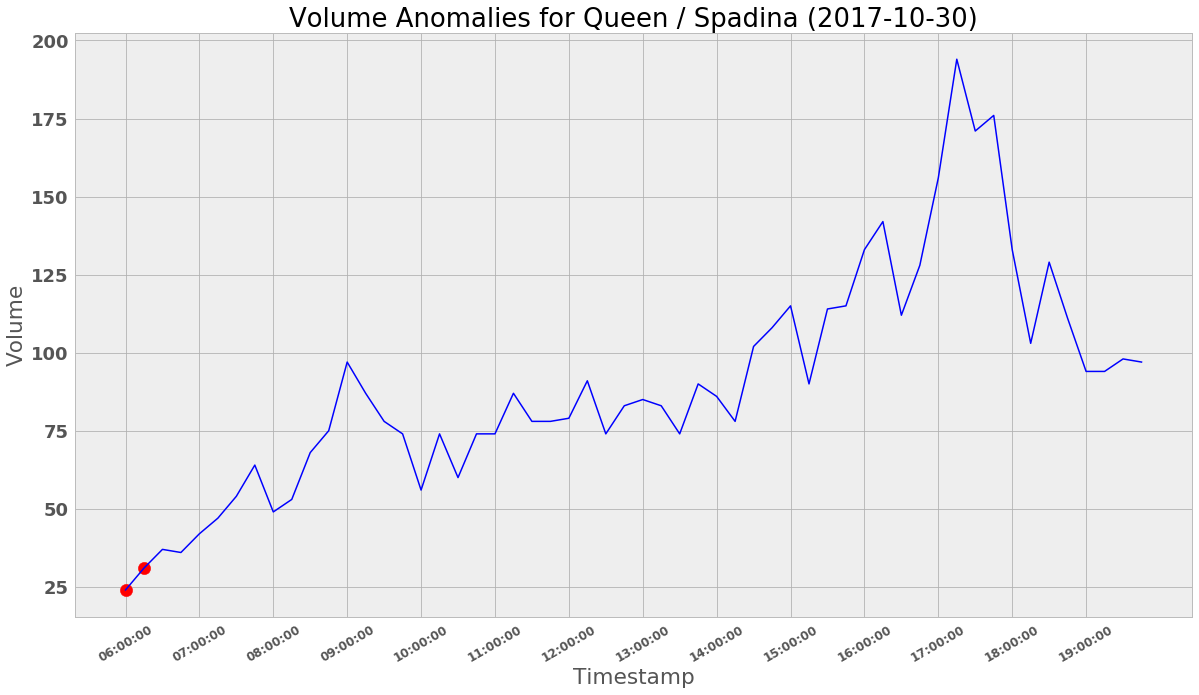

In [44]:
strSQL = '''WITH ts AS (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
            INNER JOIN miovision.intersections USING (intersection_uid)
            WHERE classification_uid in (1,4,5)
            AND intersection_name = 'Queen / Bathurst'
            AND (leg = 'W' AND dir = 'WB')
            AND datetime_bin::date = '2017-10-30'
            and extract('hour' from datetime_bin) >= 6
            and extract('hour' from datetime_bin) < 20
            GROUP BY datetime_bin
            ORDER BY datetime_bin),
            
            proper AS (SELECT datetime_bin::date, COUNT(volume)
            from ts
            group by datetime_bin::date
            having count(volume) = 56)
            
            select * from ts
            where datetime_bin::date in (select datetime_bin from proper)'''

new_dataframe = pandasql.read_sql(pg.SQL(strSQL), con)

anomalous("Monday", "Queen / Spadina", "WB", "W", new_dataframe, 95)

#### **Example 2: Detecting Anomalies for Adelaide and Jarvis**

         datetime_bin  volume  forecasted_volume outlier_type  squared error
0 2017-11-01 12:30:00   110.0         110.394304        lower       0.155476


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


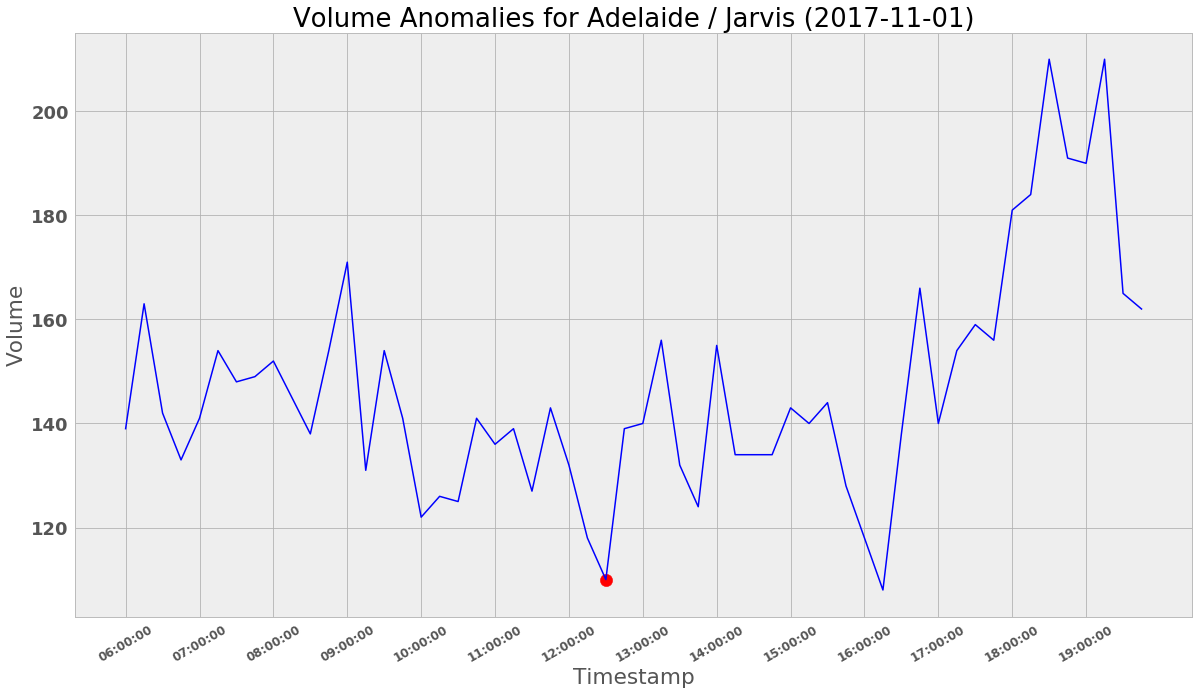

In [25]:
strSQL = '''WITH ts AS (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
            INNER JOIN miovision.intersections USING (intersection_uid)
            WHERE classification_uid in (1,4,5)
            AND intersection_name = 'Adelaide / Jarvis'
            AND (leg = 'S' AND dir = 'NB')
            AND datetime_bin::date = '2017-11-01'
            and extract('hour' from datetime_bin) >= 6
            and extract('hour' from datetime_bin) < 20
            GROUP BY datetime_bin
            ORDER BY datetime_bin),
            
            proper AS (SELECT datetime_bin::date, COUNT(volume)
            from ts
            group by datetime_bin::date
            having count(volume) = 56)
            
            select * from ts
            where datetime_bin::date in (select datetime_bin from proper)'''

new_dataframe = pandasql.read_sql(pg.SQL(strSQL), con)

anomalous("Wednesday", "Adelaide / Jarvis", "SB", "N", new_dataframe, 95)

#### **Example 3: Detecting Anomalies for Richmond and Bathurst**

Empty DataFrame
Columns: [datetime_bin, volume, forecasted_volume, outlier_type, squared error]
Index: []


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


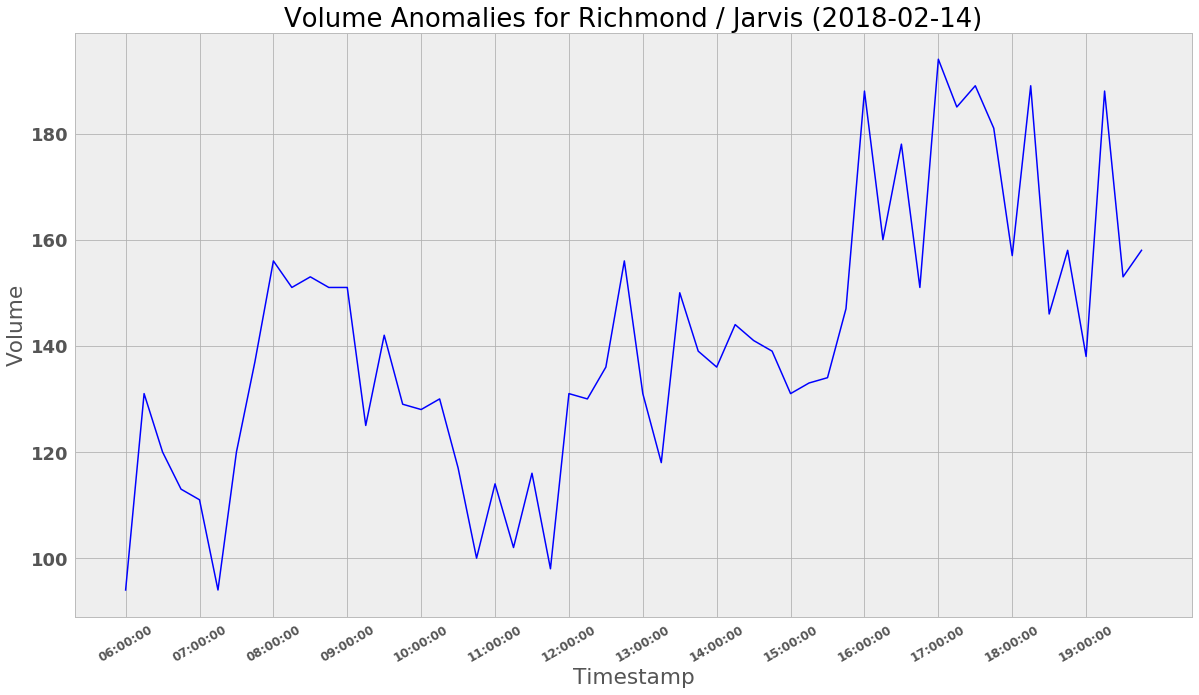

In [28]:
strSQL = '''WITH ts AS (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
            INNER JOIN miovision.intersections USING (intersection_uid)
            WHERE classification_uid in (1,4,5)
            AND intersection_name = 'Richmond / Jarvis'
            AND (leg = 'S' AND dir = 'NB')
            AND datetime_bin::date = '2018-02-14'
            and extract('hour' from datetime_bin) >= 6
            and extract('hour' from datetime_bin) < 20
            GROUP BY datetime_bin
            ORDER BY datetime_bin),
            
            proper AS (SELECT datetime_bin::date, COUNT(volume)
            from ts
            group by datetime_bin::date
            having count(volume) = 56)
            
            select * from ts
            where datetime_bin::date in (select datetime_bin from proper)'''

new_dataframe = pandasql.read_sql(pg.SQL(strSQL), con)

anomalous("Wednesday", "Richmond / Jarvis", "SB", "N", new_dataframe, 95)

# **Volume Trend Deviation**

In [37]:
def decompose(data):
    % R x <- ts(data$volume, frequency = 56)
    % R decomp <- stl(x, s.window = 'periodic')
    % R plot(decomp)
    % R decomp <- as.data.frame(decomp$time.series)
    % R -o decomp
    return pd.DataFrame(decomp)

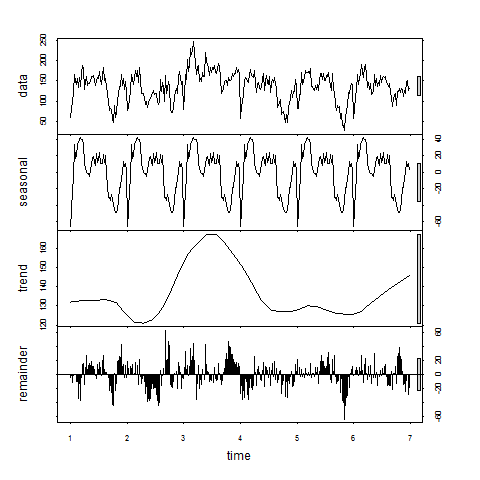

,seasonal,trend,remainder
1,-66.729361,131.969052,-5.239690
2,-47.418737,132.032316,-1.613579
3,-20.788186,132.095581,-11.307395
4,-8.824302,132.158846,-1.334543
5,34.166640,132.222110,-0.388751
6,16.657583,132.285375,0.057042
7,19.203506,132.348640,-10.552146
8,34.582762,132.411905,-9.994667
9,36.723442,132.475169,-35.198611
10,40.310204,132.538434,-13.848638


In [38]:
decompose(grab("Wednesday", "Richmond / Spadina", "NB", "S")).head(20)

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


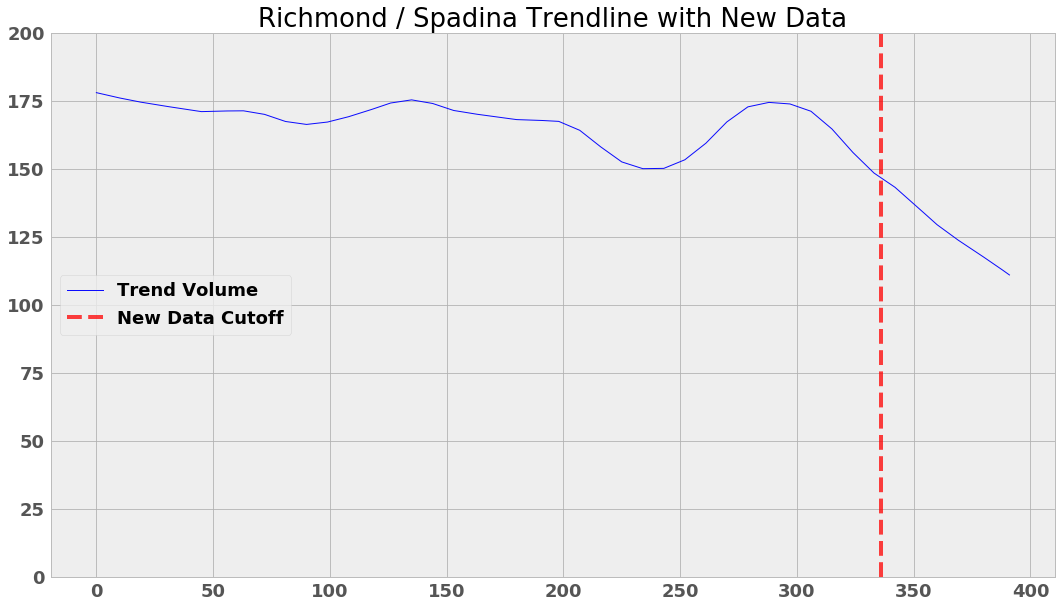

In [127]:
data = grab("Wednesday", "Richmond / Spadina", "NB", "S")
data_new = grab("Wednesday", "Richmond / Spadina", "SB", "N")[0:56]
% R -i data_new
% R -i data
% R x <- ts(append(data$volume, data_new$volume), frequency = 56)
% R decomp <- stl(x, s.window = 'periodic')
% R decomp_as_df <- as.data.frame(decomp$time.series)
% R trendvalues <- decomp_as_df$trend

#% R plot(decomp)
plt.figure(figsize = (18,10))
plt.plot(trendvalues, linewidth = 1, color = 'b', alpha = 0.95, label = 'Trend Volume')
plt.axvline(x=56*6, c = 'r', linewidth = 4, linestyle = '--', alpha = 0.75, label = 'New Data Cutoff')
plt.yticks([0,25, 50,75,100,125,150,175,200])
plt.title("Richmond / Spadina Trendline with New Data")
plt.legend(loc = 6)
plt.show()